In [329]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization 


In [330]:
from time import time
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [331]:
n_samples = 2000
n_features = 7000
n_components = 8
n_top_words = 10


def print_top_words(model, feature_names, n_top_words, P):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += str(round(P[topic_idx],2))+" "
        message += " ".join([feature_names[i]+','
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def top_words(model, feature_names, n_top_words, P, Year):
    Topic_popular =list(); topWords = list();
    for topic_idx, topic in enumerate(model.components_):
        topWords.append(list([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        Topic_popular.append(round(P[topic_idx],2))
    d = {'Popularity': Topic_popular} #pd.DataFrame(topWords, Topic_popular)
    df = pd.DataFrame(data=d)
    df['topWords'] = topWords
    df['Year'] = Year
    df.sort_values(by=['Popularity'],inplace = True, ascending=False)
    df.rename(columns={df.columns[0]: "Popularity" }, inplace = True)
    return(df)

In [332]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

# print("Loading dataset...")
# t0 = time()
# dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                              remove=('headers', 'footers', 'quotes'))
# data_samples = dataset.data[:n_samples]
# print("done in %0.3fs." % (time() - t0))

In [386]:
print("Loading dataset...")

t0 = time()
# df = pd.read_csv('IECR_articles.csv')
df = pd.read_csv('IECR-1996-2019-with-citations.csv')

for i in df.index:
    if pd.isnull(df.Abstract[i]): #
        df.Abstract[i] = ''
        
df['Date'] = pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year

print("done in %0.3fs." % (time() - t0))
df.info()

Loading dataset...
done in 3.203s.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29162 entries, 0 to 29161
Data columns (total 17 columns):
Unnamed: 0              29162 non-null int64
Category                29161 non-null object
Corresponding Author    28728 non-null object
#Authors                29162 non-null int64
Title                   29162 non-null object
Date                    29162 non-null datetime64[ns]
Journal                 29162 non-null object
Volume                  29162 non-null int64
Issue                   29162 non-null int64
Abstract                29162 non-null object
DOI                     29162 non-null object
Authors                 29162 non-null object
Type                    29162 non-null object
Year                    29162 non-null int64
Cited by                29162 non-null float64
Link                    25368 non-null object
Affiliations            25225 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(10)
memory usa

In [334]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Phrases
import warnings 
warnings.filterwarnings(action = 'ignore')
import gensim 
from nltk.corpus import stopwords
import string 

In [335]:
df = df[df['Type']=='Article']
word2vecSamples = list(df['Abstract'])

stop_words = set(stopwords.words('english'))

t0 = time()
data = []
for i in word2vecSamples:
    temp=[]    
    for j in word_tokenize(i):
        if j.lower() not in stop_words:
#             if j == 'amino':
#                 print(j)
            temp.append(j.lower().translate(str.maketrans('', '', string.punctuation)))
        
    data.append(temp) 

bigram_transformer = Phrases(data)

# Create CBOW model 
cbow_model = gensim.models.Word2Vec(bigram_transformer[data], min_count = 1,  
                              size = 200, window = 5) 
cbow_model.save("word2vec.model")
print("done in %0.3fs." % (time() - t0))

print(cbow_model.similarity('amino','acid'))

done in 228.944s.
0.6801586


In [387]:
import numpy as np

t0 = time()
print("\nExtracting tf-idf features for NMF...")

# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,ngram_range=(1, 2),
                                   stop_words='english')

df = df[df['Type']=='Article']
df.drop(columns=['Unnamed: 0'],inplace = True)
df.reset_index(inplace = True,drop=True)

tfidf_vectorizer.fit(list(df['Abstract']))

print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 21.921s.


In [458]:
print("\nFitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

HAll = []; WAll = []
dtopWords = pd.DataFrame(columns=['Popularity','topWords','Year'])

dfFinal = pd.DataFrame(columns = df.columns)

for i in range(1996,2020):
    df0 = df[(df['Year'] == i) & (df['Category']!='Mastheads')]
    
    dfFinal = dfFinal.append(df0, ignore_index = True)
    
    print(i)
#     df0 = df0[df0['Type']=='Article']
    data_samples = list(df0['Abstract'])
    
    tfidf = tfidf_vectorizer.transform(data_samples)

    # Fit the NMF model
    nmf_model = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5)
    nmf = nmf_model.fit(tfidf)

    W = nmf_model.transform(tfidf)
    H = nmf_model.components_
    
    # Popularity Ranking
    P = np.sum(W, axis = 0)/np.sum(W)  

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    topWords = top_words(nmf, tfidf_feature_names, n_top_words, P, i)
    
    HAll.append(H)
    WAll.append(W)
    dtopWords = pd.concat([dtopWords, topWords], ignore_index=True)

print("\nTopics in NMF model (Frobenius norm):")
dtopWords

    # print_top_words(nmf, tfidf_feature_names, n_top_words, P)

# # Use tf (raw term count) features for LDA.
# print("Extracting tf features for LDA...")
# tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
#                                 max_features=n_features,
#                                 stop_words='english')
# t0 = time()
# tf = tf_vectorizer.fit_transform(data_samples)
# print("done in %0.3fs." % (time() - t0))
# print()


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=7000...
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019

Topics in NMF model (Frobenius norm):


,Popularity,topWords,Year
0,0.40,"[model, liquid, reaction, data, phase, rate, t...",1996
1,0.12,"[catalyst, deactivation, coke, catalysts, zeol...",1996
2,0.11,"[control, controller, nonlinear, loop, process...",1996
3,0.10,"[problem, formulation, programming, scheduling...",1996
4,0.09,"[transfer, mass transfer, mass, transfer coeff...",1996
...,...,...,...
187,0.09,"[co2, capture, absorption, n2, co2 capture, ga...",2019
188,0.07,"[membranes, membrane, zif, water, separation, ...",2019
189,0.06,"[saft, eos, pc saft, pc, saft eos, mixtures, l...",2019
190,0.05,"[ils, il, ionic, ionic liquids, liquids, liqui...",2019


In [338]:
# #Coherence between years
# def Coherence_score0(L1, L2):
#     model = gensim.models.Word2Vec.load("word2vec.model")
#     coh = 0 #np.zeros([len(xList),len(xList)])
#     for i in range(len(L1)):
#         for j in range(len(L2)):
#             coh = coh + model.similarity(L1[i].split(' ', 1)[0], L2[j].split(' ', 1)[0]) 
#     nCombs = len(L1)*len(L2)
#     coh = coh/nCombs  
#     return(coh)

# def Coherence0(T1,T2):
# #     model = gensim.models.Word2Vec.load("word2vec.model")
#     out = np.zeros([2, len(T2)]) #np.zeros([len(xList),len(xList)])
#     for i in range(len(T2)):
#         temp = []
#         for j in range(len(T1)):
#             temp.append(Coherence_score0(T1[j], T2[i]))
            
#         out[0,i] = max(temp)
#         out[1,i] = temp.index(max(temp))+1                       
#     return(out)
                       
# x1 = list(dtopWords[dtopWords['Year']==2018].topWords)
# x2 = list(dtopWords[dtopWords['Year']==2019].topWords)

# t0 = time()
# xx = Coherence0(x1,x2)
# print("done in %0.3fs." % (time() - t0))

# print(xx.T)

In [460]:
HAll = np.vstack(HAll)
# print(len(data_samples))
# print((tfidf.shape))
#Fit the NMF model
nmf_model = NMF(n_components=15, random_state=1,
          alpha=.1, l1_ratio=.5)

nmf = nmf_model.fit(HAll)
U = nmf_model.transform(HAll)
L = nmf_model.components_

similarity = np.zeros([L.shape[0],L.shape[0]])
similarity.fill(np.nan)
for i in range(L.shape[0]):
    for j in range(0,i):
        similarity[i,j] = np.dot(L[i],L[j])/(np.linalg.norm(L[i])*np.linalg.norm(L[j]))

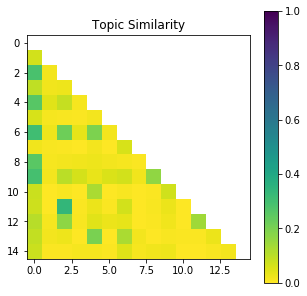

,Popularity,topWords,Year
0,0.14,"[reaction, rate, temperature, reactor, model, ...",All
2,0.11,"[process, model, proposed, optimization, probl...",All
6,0.09,"[data, liquid, model, equation, phase, experim...",All
9,0.08,"[spectroscopy, electron, microscopy, surface, ...",All
1,0.07,"[co2, capture, co2 capture, gas, absorption, m...",All
3,0.07,"[adsorption, adsorbent, capacity, adsorption c...",All
4,0.07,"[flow, bed, gas, reactor, liquid, velocity, bu...",All
8,0.07,"[catalyst, catalysts, catalytic, activity, ni,...",All
5,0.06,"[membrane, membranes, flux, separation, water,...",All
11,0.06,"[control, controller, loop, nonlinear, feedbac...",All


In [461]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.set_cmap('viridis_r')
im = ax.imshow(similarity,vmin=0, vmax=1)
plt.title('Topic Similarity')
fig.colorbar(im, ax=ax)
plt.show()
                                             
# Popularity Ranking
P = np.sum(U, axis = 0)/np.sum(U) 
n_top_words = 10
dSup = top_words(nmf, tfidf_feature_names, n_top_words, P, 'All')

dSup.to_pickle("dSup.pkl")
dSup

In [913]:
# WAll0 = np.vstack(WAll)
Year = 1996
P = []
LHSmega = []
for i in range(len(WAll)):
    W = WAll[i]
    UYear = U[i*8:(i+1)*8]
    LHS = np.matmul(W,UYear)
    LHSmega.append(LHS)
    Year = Year+1
    # Popularity Ranking
    P.append(np.sum(LHS, axis = 0)/np.sum(LHS))

P=np.vstack(P)
avgP = np.mean(P, axis=1) #np.ones([(2020-1996),1])*

np.save('PFile', P)

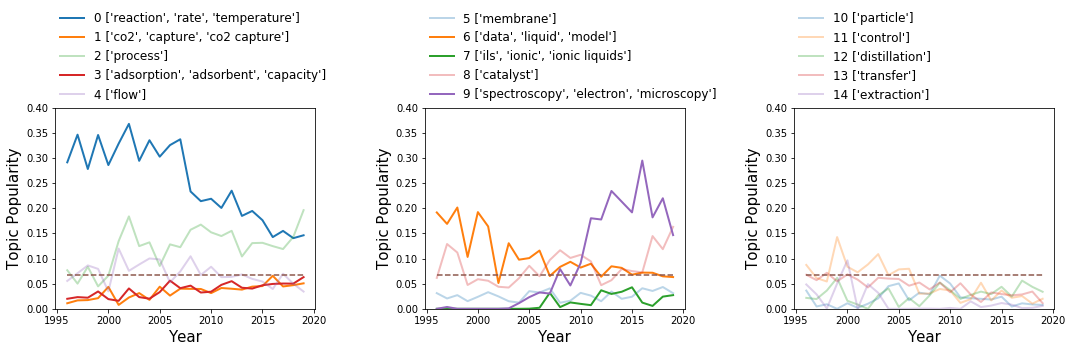

In [923]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dSup = pd.read_pickle("dSup.pkl")
P = np.load('PFile.npy') 

Years = range(1996,2020)
# order = [0,3,4,9,11,1,2,5,6,7,8,10,12,13,14]
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout = True)
start = 0
for s in range(3):
    end = start + 5
    for i in range(start,end):
        if i==1 or i==3 or i==7 or i==9 or i==6 or i==0:
            ax[s].plot(Years,P[:,i],'-',label=str(i)+' '+str(dSup.topWords[i][:3]), lw = 2)
        else:
            ax[s].plot(Years,P[:,i],'-',label=str(i)+' '+str(dSup.topWords[i][:1]),alpha = 0.3, lw = 2)
    ax[s].plot(Years,avgP,'--')
    ax[s].set_xlabel('Year', fontsize=15)
    ax[s].set_ylabel('Topic Popularity', fontsize=15)
    ax[s].set_ylim([0, 0.4])
    ax[s].legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1, 
            borderaxespad=0, frameon=False, fontsize=12)
    start = end
plt.show()

In [464]:
#Coherence Scores
def Coherence_score(xList):
    model = gensim.models.Word2Vec.load("word2vec.model")
    coh = 0 #np.zeros([len(xList),len(xList)])
    for i in range(1,len(xList)):
        for j in range(0,i-1):
             coh = coh + model.similarity(xList[i].split(' ', 1)[0], xList[j].split(' ', 1)[0]) 
    nCombs = len(xList)*(len(xList)-1)/2
    coh = coh/nCombs  
    return(coh)


xList1 = list(dtopWords[dtopWords['Year']==2018].topWords)[0]
coh = np.zeros(len(xList1))
for i in range(len(xList1)):
    coh[i] = Coherence_score(xList1[i])

print(coh)

[0.52237442 0.41197641 0.67996829 0.5465995  0.24184644 0.68011738
 0.65866813 0.69011381 0.72204915 0.59433021]


In [344]:
# # Fit the NMF model
# print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
#       "tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

# print("Fitting LDA models with tf features, "
#       "n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)
# t0 = time()
# lda.fit(tf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in LDA model:")
# tf_feature_names = tf_vectorizer.get_feature_names()
# print_top_words(lda, tf_feature_names, n_top_words)

In [756]:
from matplotlib.ticker import MaxNLocator
year1 = range(1999,2019)
Years = range(1996,2020)
totPapers = []
for i in Years:
    totPapers.append(len(df[df['Year'] == i]))
impactFactor = [1.39, 1.421, 1.423, 1.425, 1.42, 1.643, 1.787, 1.739, 1.907, 1.95, 1.894, 2.391, 2.665, 2.591, 2.633, 2.987, 2.898, 3.104, 3.349, 3.539]

# Impact Factor
avgTot = []
year2 = []
for i in range(1996,2019):
    if i != 2004:
        dfTemp = df[(df.Year == i)]
        Citations = dfTemp['Cited by']
        avgTot.append(round(np.mean(Citations)/(2019-i),2))
        year2.append(i)
    
print(avgTot)
# year2 = np.arange(1996,2019)

[1.26, 1.32, 1.27, 1.34, 1.62, 1.5, 1.75, 1.4, 2.25, 2.55, 2.37, 2.34, 2.8, 2.63, 2.81, 3.02, 3.12, 3.34, 3.38, 3.5, 3.39, 3.17]


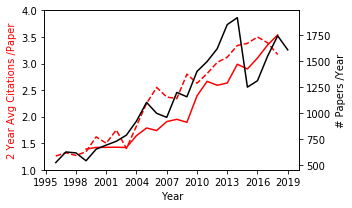

In [757]:
fig, ax = plt.subplots(1,1,figsize=(5,3),tight_layout=True)

color = tuple([x/255 for x in (255,0,0)]+[1])
ax.plot(year1,impactFactor,'-',color=color)
ax.plot(year2,avgTot,'--',color=color)
ax.set_xlabel('Year')
ax.set_ylabel('2 Year Avg Citations /Paper', color=color)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim((1, 4))

color = tuple([x/255 for x in (0,0,0)]+[1])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(Years,totPapers,'-',color=color)
ax2.set_ylabel('# Papers /Year',color=color)
plt.show()

In [484]:
import seaborn as sns
dfPlot = dfFinal[dfFinal['Year']>=1996]
dfPlot['#Authors'] = dfPlot['#Authors'].astype(float)

dfPlot.to_pickle("dIECR.pkl")
dfPlot = pd.read_pickle("dIECR.pkl")

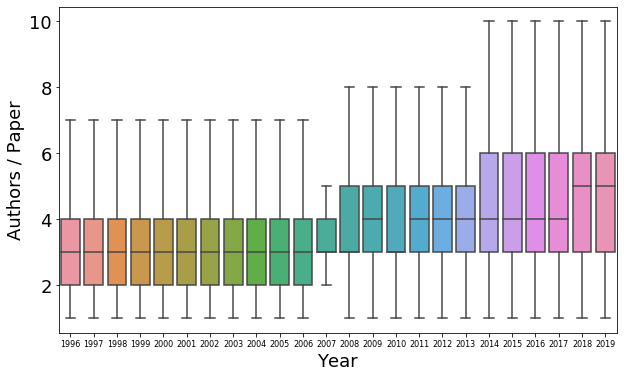

In [485]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="Year", y="#Authors",
              data=dfPlot, showfliers=False)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Authors / Paper', fontsize=18)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=18)
plt.show()

In [486]:
num = 0
for i in range(len(WAll)):
    num = num + WAll[i].shape[0]
print(num)
print(len(df))

26867
27259


In [487]:
print('Years =',len(LHSmega))
print('Shape of LHSmega for Year 0 =', LHSmega[0].shape)
print('No of entries in Year 0 =',len(df[df.Year==1996]))

Years = 24
Shape of LHSmega for Year 0 = (524, 15)
No of entries in Year 0 = 524


In [488]:
def argFunc(x):
    args = np.flip(np.argsort(x)[-4:])  
    vals = np.flip(np.sort(x)[-4:])
    args[np.argwhere(np.isnan(vals))] = -111
    return args
def valFunc(x):
    vals = np.flip(np.sort(x)[-4:])
    vals[np.argwhere(np.isnan(vals))] = 0
    return vals

args = []; vals = []
for i in range(len(LHSmega)):
    LHSsum = np.sum(LHSmega[i], axis = 1)
    args.append(np.apply_along_axis(argFunc, 1, (LHSmega[i]/LHSsum[:,None])))
    vals.append(np.apply_along_axis(valFunc, 1, (LHSmega[i]/LHSsum[:,None])))

argsAll = np.vstack(args)
valsAll = np.vstack(vals)

['reaction', 'rate', 'temperature']


,Category,Corresponding Author,#Authors,Title,Date,Journal,Volume,Issue,Abstract,DOI,Authors,Type,Year,Cited by,Link,Affiliations
0,Articles,Miguel A. Gutiérrez-Ortiz,4,Yield and Purity Comparison of Dimethoate Manu...,1996-12-04,IECR,35,12,"The process for manufacturing dimethoate (O,O-...",10.1021/ie9603474,"['Juan R. González-Velasco', 'José A. González...",Article,1996,0.0,https://www.scopus.com/inward/record.uri?eid=2...,"Depto. de Ing. Química, Facultad de Ciencias, ..."
5,Articles,Garry L. Rempel,3,RhCl(PPh3)3 and RhH(PPh3)4 Catalyzed Hydrogena...,1996-12-04,IECR,35,12,Homogeneous catalyst precursors of the forms R...,10.1021/ie9506680,"['J. Scott Parent', 'Neil T. McManus', 'Garry ...",Article,1996,0.0,NaN,NaN
6,Articles,J. Aittamaa,4,Kinetics of the Liquid Phase Hydrogenation of ...,1996-12-04,IECR,35,12,The liquid phase hydrogenation kinetics of fiv...,10.1021/ie950636c,"['S. Toppinen', 'T.-K. Rantakylä', 'T. Salmi',...",Article,1996,23.0,https://www.scopus.com/inward/record.uri?eid=2...,"Neste Engineering, P.O. Box 310, FIN-06101 Por..."
8,Articles,Juan M. Rodríguez Patino,4,Surface Rheological Properties of Monostearin ...,1996-12-04,IECR,35,12,The surface viscoelastic properties of monoste...,10.1021/ie960333y,"['M. Rosario Rodríguez Niño', 'Peter J. Wilde'...",Article,1996,24.0,https://www.scopus.com/inward/record.uri?eid=2...,"Depto. de Ing. Química, Facultad de Química, U..."
9,Articles,Peter Harriott,3,Measurement of Diffusivity and Solubility of C...,1996-12-04,IECR,35,12,The effect of pressure on diffusivity in binar...,10.1021/ie960295,"['Bhajmohan Singh', 'Syed S. H. Rizvi', 'Peter...",Article,1996,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21018,"Thermodynamics, Transport, and Fluid Mechanics",Muthanna H. Al-Dahhan*,2,Impact of Internals Size and Configuration on ...,2015-01-06,IECR,54,4,Bubble columns have been used in a wide range ...,10.1021/ie503490h,"['Moses Kagumba', 'Muthanna H. Al-Dahhan*']",Article,2015,29.0,https://www.scopus.com/inward/record.uri?eid=2...,Department of Chemical and Biochemical Enginee...
21020,General Research,Atsushi Kishita,5,An in Situ Raman Spectroscopic Study of Benzot...,2015-01-09,IECR,54,4,"In this paper, an in situ Raman spectroscopic ...",10.1021/ie503167q,"['Zhibao Huo', 'Fangming Jin*', 'Guodong Yao',...",Article,2015,2.0,https://www.scopus.com/inward/record.uri?eid=2...,School of Environmental Science and Engineerin...
21040,"Thermodynamics, Transport, and Fluid Mechanics",Gabriele Sadowski*,3,Measurement and Modeling of Phase Equilibria i...,2015-01-05,IECR,54,3,This work presents a modeling approach using t...,10.1021/ie502557g,"['Ole Riechert', 'Tim Zeiner', 'Gabriele Sadow...",Article,2015,9.0,https://www.scopus.com/inward/record.uri?eid=2...,Department of Biochemical and Chemical Enginee...
21041,"Thermodynamics, Transport, and Fluid Mechanics",Xuefeng He,7,Coalescence with Droplets Caused Acceleration ...,2015-01-05,IECR,54,3,The coalescence between liquid flow and drople...,10.1021/ie5044133,"['Qiang Liao', 'Shuzhe Li', 'Rong Chen*', 'Hon...",Article,2015,2.0,https://www.scopus.com/inward/record.uri?eid=2...,Key Laboratory of Low-Grade Energy Utilization...


# Analyzing Citations

In [494]:
def splitName(df):    
    if (pd.isnull(df['Corresponding Author'])) | (df['Corresponding Author']=='NA'):
        x = 'NA'
    else:
        x = word_tokenize(df['Corresponding Author'])
        for i in range(len(x)-1):
            x[i] = x[i][0]
        x = ' '.join(x).rsplit('*')[0]
    return x

def citationsPerYear(df):
    x = round(df['Cited by']/(2020-df['Year']),2)
    return(x)

t0 = time()
dfPlot['Corresponding Author'] = dfPlot.apply(lambda x: splitName(x), axis = 1)
dfPlot['Annual Citations'] = dfPlot.apply(lambda x: citationsPerYear(x), axis = 1)
print("done in %0.3fs." % (time() - t0))

done in 8.093s.


# Analysis of Overall Authors

In [513]:
def getTotCitations(df,Author):
    da = pd.DataFrame() #columns = ['Year','CumCit','Author'])
    auth = []
    citations = []
    year = []
    nPaper = []
    cit = 0; nP = 0
    x = pd.DataFrame()
    for j in range(1996,2020):
        dfTemp = df[df['Year']==j]
        if len(dfTemp) > 0:
            cit = cit + dfTemp['Annual Citations'].sum()
            nP = nP + len(dfTemp)
            citations.append(cit)
            year.append(j)
            auth.append(Author)
            nPaper.append(nP)
    da['Year']=year
    da['CumCit'] = citations
    da['Author'] = auth
    da['nPapers'] = nPaper
    return da

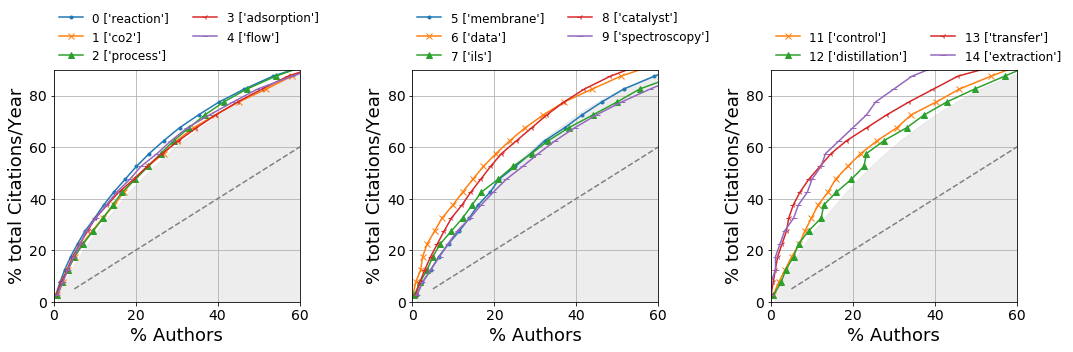

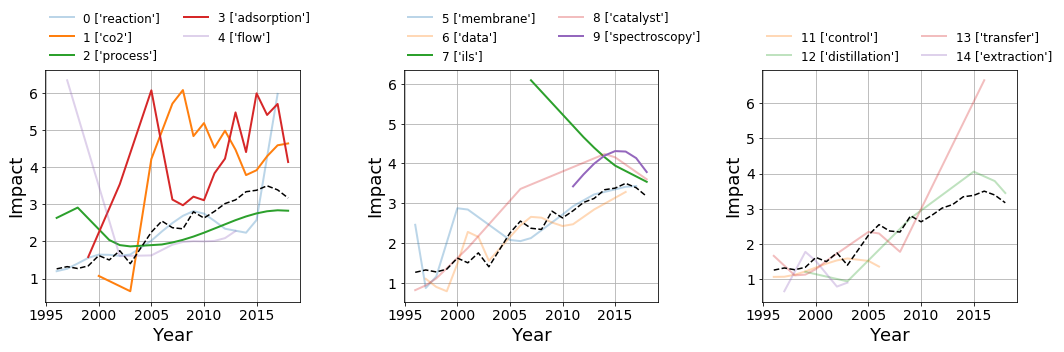

In [922]:
from scipy.interpolate import UnivariateSpline
from matplotlib import cm
import math
    
tol = 0.33
fig, axs = plt.subplots(1,3,figsize=(15,5),tight_layout = True)
fig2, axs2 = plt.subplots(1,3,figsize=(15,5),tight_layout = True)

marker = ['.','x','^','3','_']

Topics = np.arange(0,15) #[0,1,2,3,4,6,7,8,9,11]
Topics = Topics[Topics!=10]
mydata = []
# nCm = 0;
for topic in Topics:  
    nCm = topic - math.floor(topic/5)*5
    color=cm.tab10(nCm)
    ind = []
    for i in range(1):
        topicInds  = (np.argwhere(argsAll[:,i] == topic))
        if topicInds != []:
            topicInds = np.concatenate(topicInds)
        feasInds = (np.argwhere(valsAll[:,i] >= tol))
        if feasInds != []:
            feasInds = np.concatenate(feasInds)
        ind.append((np.intersect1d(topicInds, feasInds)))

#     print(str(dSup.topWords[topic][:3]))
    ind = np.hstack(ind)

    dfTemp = dfPlot.loc[ind]
    UniqueAuthors = dfTemp['Corresponding Author'].unique()
    totAuth = len(UniqueAuthors)

    UB = np.arange(0.05,1,0.05)
    nAuth = []
    for upperBound in UB:
        lowerBound = upperBound - 0.05
        df0New = dfTemp['Annual Citations'].sort_values(ascending=False).cumsum()
        df0New = df0New[(df0New <= upperBound*np.sum(dfTemp['Annual Citations']))]
    #                    &(df0New >= lowerBound*np.sum(dfTemp['Annual Citations']))]
        # totAnnCit = np.sum(dfTemp['Annual Citations'])
        df0New = dfTemp.loc[df0New.index]
        CitedUniqueAuthors = df0New['Corresponding Author'].unique()
        nAuth.append(len(CitedUniqueAuthors))

    ii = math.floor(topic/5)
    axs[ii].plot(np.hstack(nAuth)/totAuth*100,(UB-0.025)*100,'-o',label=str(topic)+' '+str(dSup.topWords[topic][:1]),
                color=color,marker=marker[nCm])
    
    mydata.append(dfTemp[dfTemp['Annual Citations'] <=30]['Annual Citations'])
    avg = []
    year2 = []
    for year in range(1996,2019):
        df0 = dfTemp[(dfTemp.Year == year) & (dfTemp.Year != 2004)]
        if len(df0) > 0:
            year2.append(year)
            Citations = df0['Cited by']
            avg.append(round(np.mean(Citations)/(2019-year),2))
    spl = UnivariateSpline(year2, avg)
    spl.set_smoothing_factor(1)
    if topic==1 or topic==3 or topic==7 or topic==9 or topic==2:
#         axs2[ii].plot(year2,avg,'o',color=color,marker=marker[nCm])
        axs2[ii].plot(year2,spl(year2),'-',color=color, lw = 2,
                    label=str(topic)+' '+str(dSup.topWords[topic][:1]))
    else:
#         axs2[ii].plot(year2,avg,'o',color=color,marker=marker[nCm], alpha = 0.3)
        axs2[ii].plot(year2,spl(year2),'-',color=color, lw = 2, alpha = 0.3,
                    label=str(topic)+' '+str(dSup.topWords[topic][:1]))      
    
#     weights=np.zeros_like(mydata) + 1. / mydata.size
#     axs[ii].hist(mydata, bins = 35, alpha = 0.75) #, weights=np.zeros_like(mydata) + 1. / mydata.size, )
    

dfTemp = dfPlot
UniqueAuthors = dfTemp['Corresponding Author'].unique()
totAuth = len(UniqueAuthors)

UB = np.arange(0.05,1,0.05)
nAuth = []
for upperBound in UB:
    lowerBound = upperBound - 0.05
    df0New = dfTemp['Annual Citations'].sort_values(ascending=False).cumsum()
    df0New = df0New[(df0New <= upperBound*np.sum(dfTemp['Annual Citations']))]
#                    &(df0New >= lowerBound*np.sum(dfTemp['Annual Citations']))]
    # totAnnCit = np.sum(dfTemp['Annual Citations'])
    df0New = dfTemp.loc[df0New.index]
    CitedUniqueAuthors = df0New['Corresponding Author'].unique()
    nAuth.append(len(CitedUniqueAuthors))
    
for ii in range(3):
    axs[ii].set_xlim([0, 60])
    axs[ii].set_ylim([0, 90])
#     axs[ii].plot(np.hstack(nAuth)/totAuth*100,(UB-0.025)*100,'k-')
    axs[ii].fill_between(np.hstack(nAuth)/totAuth*100,(UB-0.025)*100,color='gainsboro', alpha = 0.5)
    axs[ii].plot(UB*100, UB*100, '--', color =  '0.5')
    axs[ii].tick_params(axis="x", labelsize=14)
    axs[ii].tick_params(axis="y", labelsize=14)
    axs[ii].set_xlabel('% Authors', fontsize=18)
    axs[ii].set_ylabel('% total Citations/Year', fontsize=18)
    axs[ii].legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
            borderaxespad=0, frameon=False, fontsize=12)
    axs[ii].grid(which='major', axis='both')

year2 = np.arange(1996,2019)
year2 = year2[year2!=2004]
for ii in range(3):
    ## axs[ii].set_xlim([0, 30])
    # axs[ii].boxplot(mydata, showfliers=False)
    # xtickNames = plt.setp(axs[ii], xticklabels=Topics)
    # plt.setp(xtickNames, fontsize=8)
    axs2[ii].plot(year2,avgTot,'k--')
    axs2[ii].tick_params(axis="x", labelsize=14)
    axs2[ii].tick_params(axis="y", labelsize=14)
    axs2[ii].set_xlabel('Year', fontsize=18)
    axs2[ii].set_ylabel('Impact', fontsize=18)
    axs2[ii].legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2, 
            borderaxespad=0, frameon=False, fontsize=12)
    axs2[ii].grid(which='major', axis='both')
    # axs[i].yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.show()

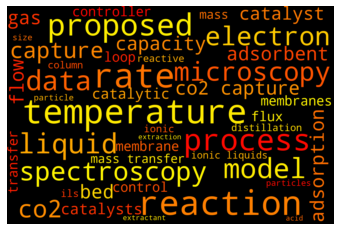

In [909]:
# Create a list of word
text = []
freq = []
for i in range(len(dSup)):
    for j in range(3):
        text.append(dSup.loc[i].topWords[j])
        freq.append(float(dSup.loc[i].Popularity))
        
freq = np.hstack(freq)
text = np.hstack(text)
dictionary = dict(zip(text, freq))

# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the wordcloud object
wordcloud = WordCloud(width=480*3, height=480*2, margin=0, colormap='autumn',max_font_size=150, min_font_size=30,
                      background_color='black').fit_words(dictionary)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=10, y=10)
plt.show()

In [899]:
# UniqueAuthors = dfTemp['Corresponding Author'].unique()
# CitedUniqueAuthors = df0New['Corresponding Author'].unique()
# print(len(CitedUniqueAuthors))
# print(len(UniqueAuthors))

# t0 = time()
# dfAuth = pd.DataFrame()
# for i in UniqueAuthors:
#     df20 = dfTemp[(dfTemp['Corresponding Author']==i)]
#     df2 = getTotCitations(df20,i)
# #     print(df2)
#     dfAuth = dfAuth.append(df2, ignore_index=True)

# dfAuthHigh = pd.DataFrame()
# for i in CitedUniqueAuthors:
#     df20 = df0New[(df0New['Corresponding Author']==i)]
#     df2 = getTotCitations(df20,i)
# #     print(df2)
#     dfAuthHigh = dfAuthHigh.append(df2, ignore_index=True)

# # print(dfAuth)
# print("done in %0.3fs." % (time() - t0))

In [535]:
# i = UniqueAuthors[9]
# print(i)
# df02 = dfTemp[(dfTemp['Corresponding Author']==i)] #| (dfPlot['Corresponding Author']=='L Jiang')]

# # import matplotlib.mlab as mlab
# from scipy.stats import expon
# fig, axs = plt.subplots(1,1,figsize=(4,4),tight_layout=True)
# df02['Annual Citations'].sort_values().plot.hist(bins=10)
# plt.show()
# round(np.mean(df02['Annual Citations']),2)

# # # best fit of data
# # (loc, scale) = expon.fit(df02['Annual Citations'].sort_values())
# # n, bins, patches = plt.hist(df02['Annual Citations'].sort_values(), 20, normed=1, facecolor='green', alpha=0.75)
# # # add a 'best fit' line
# # y = expon.pdf( bins, loc, scale)
# # l = plt.plot(bins, y, 'r--', linewidth=2)
# # expon.mean(mean,scale)

In [496]:
# t0 = time()
# dfAuth2 = pd.DataFrame()
# for i in UniqueAuthors[5000:]:
#     df20 = dfPlot[(dfPlot['Corresponding Author']==i)]
#     df2 = getTotCitations(df20,i)
# #     print(df2)
#     dfAuth2 = dfAuth2.append(df2, ignore_index=True)
    
# print("done in %0.3fs." % (time() - t0))

# dfAuth = dfAuth.append(dfAuth2, ignore_index=True)
# dfAuth.to_pickle("dAuthIECR.pkl")

In [ ]:
# dfAuth = pd.read_pickle("dAuthIECR.pkl")
# # dfAuth.sort_values(by=['Author'],inplace = True)

# dfCumAuth = pd.DataFrame()
# sumdf = pd.DataFrame()
# for i in UniqueAuthors:
#     sumdf['sum'] = (dfAuth[dfAuth['Author']==i]['nPapers']).sum()    
#     sumdf['Citsum'] = (dfAuth[dfAuth['Author']==i]['CumCit']).sum()
#     sumdf['Auth'] = i
#     dfCumAuth = dfCumAuth.append(sumdf)
    
# dfCumAuth.to_pickle("dCumAuthIECR.pkl")